<a href="https://colab.research.google.com/github/Xixaus/Nastroje/blob/main/Standardni_pridavek_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metoda standardního přídavku


- Program slouží k výpočtu koncentrace vzorku pomocí metody standardního přídavku nebo standardního přídavku za konstantního objemu a vytvoření příslušného grafu
- Nejdříve se připojte k hostujícímu prostředí v pravé horní části (musíte být přihlášený ke Google účtu)
- Poté zadejte do první buňky hodnoty !podle návodu!, výpočet a graf vygenerujete spuštěním druhé buňky tlačítkem ▶ v levém horním rohu vedle nadpisu
- Při prvním spuštění se instaluje potřebná knihovna, tak to trvá déle, další výpočty jsou okamžité

- !!!Všechny objemy zadávejte ve stejných jednotkách, jednotlivá měření stejného roztoku oddělujte pomocí středníku (;), odezvy a objemy jednotlivých standardů pomocí lomítka (/)!!!

- V_unit: zadejte jednotku objemu, ve které budete zadávat všechny objemy (bez indexů)
- R_unit: zadejte jednotku měřené veličiny, která bude na y ose v grafu
- X_axys_name: zvolte v čem chcete mít X osu
- V_flask: zadejte objem odměrné baňky, v případě nezadání bude koncentrace vypočtena metodou přídavku standardu za zvýšení objemu
- V_sample: zadejte objem odpiptovaného vzorku, který je odpipetován do odměrné baňky nebo se k němu přidává standard
- R_sample: zadejte odezvy vzorku (např: 0.200; 0.204; 0.206)
- c_standard: zadejte koncentraci standardu
- c_unit: zadejte jednotku koncentrace standardu (bez indexů)
- V_standards: zadejte objemy přidaných standardů (např: 2.0 / 4.0 / 6.0 / 8.0 / 10.0)
- R_standard: zadejte odezvy odezvy standardů (např: 0.365; 0.360; 0.375 / 0.514; 0.51; 0.518)
- Pomocí volby Save_graph můžete graf uložit ve formátu .svg, který se nachází ve složce soubory v levé části obrazovky pod ikonou 📁 s názvem graph.svg. Dvojklikem soubor stáhnete

V případě že některá hodnota bude odlehlá od kalibrační závislosti, be červěně zbarvená v tabulce pro test odlehlých hodnot




In [4]:
#@title Vstupní hodnoty { run: "auto", vertical-output: true }
V_unit = 'ul' #@param {type:"string"}
R_unit = "AU.s" #@param {type:"string"}
X_axys_name = "Pridany objem standardu" #@param ["Zvysena koncentrace", "Pridany objem standardu"]
V_flask = 10000#@param {type:"number"}
V_sample =  1000#@param {type:"number"}
R_sample = "49,755; 53,591; 63,309" #@param {type:"string"}
c_standard =  100#@param {type:"number"}
c_unit = '%' #@param {type:"string"}
V_standards = "10"#@param {type:"string"}
R_standards = "290,722; 284,03; 285"#@param {type:"string"}
prediction_band = True #@param {type:"boolean"}
outlier_test = True #@param {type:"boolean"}

                            OLS Regression Results                            
Dep. Variable:          Odezva [AU.s]   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
No. Observations:                   6   F-statistic:                     2587.
Covariance Type:            nonrobust   Prob (F-statistic):           8.94e-07
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Úsek             55.5517      3.212     17.297      0.000      46.635      64.469
Odezva [AU.s]    23.1032      0.454     50.866      0.000      21.842      24.364



,Vzorek
Koncetrace analytu [%],0.240
Směrodatná odchylka [%],0.018
Relativní směrodatná odchylka %,7.3
Interval spolehlivosti 95% [%],0.049


,Přidaný standard [ul],Odezva [AU.s],G
0,0.0,49.755,1.28
1,0.0,53.591,0.43
2,0.0,63.309,1.71
3,10.0,290.722,0.91
4,10.0,284.030,0.56
5,10.0,285.000,0.35


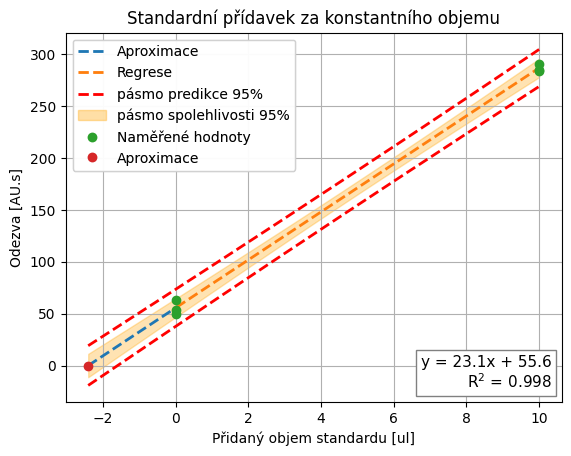

In [7]:
#@title Graf s výsledkem

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
from IPython.display import display, HTML

import warnings
warnings.simplefilter('ignore', sm.tools.sm_exceptions.ValueWarning)
warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def data_extract(V_standards, R_sample, R_standards):
    str1 = ("0 / " + V_standards).replace(",", ".")
    str2 = (R_sample + " / " + R_standards).replace(",", ".")

    list1, list2, data = str1.split('/'), str2.split('/'), []

    for i in range(len(list2)):
        for num in list2[i].split(';'):
            data.append([float(list1[i]), float(num)])

    col = [f"Přidaný standard [{V_unit}]", f"Odezva [{R_unit}]"]

    return(pd.DataFrame(data, columns=col))

def std_reg(df, model):
    if model.df_resid == 0:
      return (0)

    x, y = df.iloc[:,0].values, df.iloc[:,1].values
    intercept = model.params[1]
    sxx = np.var(x, ddof=0) * len(x) #čitatel kovarience xx
    Sy = np.sqrt(model.scale) #Směrodatná odchylka regrese

    Sx = (Sy/abs(intercept)) * np.sqrt((1/len(x))+(y.mean()**2/((intercept**2)*sxx))) #směrodatná odchylka výsledku
    return (Sx)

def evaluation(model, df, sample,c_unit):
    Sx = std_reg(df, model)

    if V_flask == None: #výpočet koncetrace v případě volby metody standardního přídavku
        if X_axys_name == "Zvysena koncentrace":
          final_sample = sample #výpočet koncentrace vzorku
          final_sample_st_dev = Sx
          sample_name = "Zvýšená koncentrace roztoku vzorku"
        else:
          final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
          final_sample_st_dev = Sx * c_standard / V_sample
          sample_name = "Objem standardu ve vzorku"

    else: #výpočet koncetrace v případě volby metody standardního přídavku za konstantního objemu
        if X_axys_name == "Zvysena koncentrace":
          final_sample = sample * V_flask / V_sample #výpočet koncentrace vzorku
          final_sample_st_dev = Sx * V_flask / V_sample
          sample_name = "Koncetrace roztoku vzorku"
        else:
          final_sample = sample * c_standard / V_sample #přepočtení objemu standardu na koncentraci
          final_sample_st_dev = Sx * c_standard / V_sample
          sample_name = "Objem standardu ve vzorku"

    if model.df_resid == 0:
        final_sample_con_int = 0
    else:
        final_sample_con_int = final_sample_st_dev * scipy.stats.t.ppf(q=0.975,df=model.df_resid) #výpočet intervalu spolehlivosti 0,05

    Rel_std = final_sample_st_dev/final_sample * 100

    result = pd.DataFrame(index=[f'Koncetrace analytu [{c_unit}]', f'Směrodatná odchylka [{c_unit}]', "Relativní směrodatná odchylka %", f"Interval spolehlivosti 95% [{c_unit}]"])
    sig_num = -(int(str('%.2e' % final_sample_st_dev)[-3:])-1)

    result["Vzorek"] = [final_sample, final_sample_st_dev, Rel_std, final_sample_con_int]
    result.loc["Relativní směrodatná odchylka %"] = result.loc["Relativní směrodatná odchylka %"].apply(lambda x: f'{x:.1f}')

    for index in result.index:
      if index != "Relativní směrodatná odchylka %":
          result.loc[index, "Vzorek"] = f'{result.loc[index, "Vzorek"]:.{sig_num}f}'

    return (result)

def outlier_value(model):
  df = data_extract(V_standards, R_sample, R_standards)
  #df.index = df.index + 1
  residuals = model.resid
  Sxy = np.sqrt(model.scale)
  df["G"] = abs(residuals) / Sxy * np.sqrt(model.nobs/model.df_resid)

  t_crit = scipy.stats.t.ppf(1 - 0.1/(2*model.nobs), df=model.nobs-2)
  G_crit = ((model.nobs-1) * t_crit) / np.sqrt(model.nobs * (model.nobs-2 + t_crit**2))

  def highlight_rows(row):
      if row['G'] > G_crit:
          return ['background-color: red']*len(row)
      else:
          return ['']*len(row)

  def count_decimals(x):
    if isinstance(x, float):
        return len(str(x).split('.')[1])
    else:
        return 0

  df_0_decimals, df_1_decimals = df[df.columns[0]].apply(count_decimals).max(), df[df.columns[1]].apply(count_decimals).max()

  df = df.style.apply(highlight_rows, axis=1).format({df.columns[0]: "{:." + str(df_0_decimals) + "f}",
                                                      df.columns[1]: "{:." + str(df_1_decimals) + "f}",
                                                      "G": "{:.2f}"}
                                                     ).set_caption(f'<h2 style="font-weight: bold;">G crit 95% = {G_crit:.2f}</h2>')
  return (df)

def intervals(model, df, sample):
    x = df.iloc[:,0]
    y = df.iloc[:,1]
    t = scipy.stats.t.ppf(0.975, model.df_resid)

    x_line = np.linspace(-sample, np.max(x), 200)
    y_line = model.predict(sm.add_constant(x_line))

    ci = t * np.sqrt(model.scale) * (1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5
    pi = t * np.sqrt(model.scale) * (1 + 1/model.nobs + (x_line - x.mean())**2 / np.sum((x - x.mean())**2))**.5

    return(pd.DataFrame([x_line, y_line,  y_line+pi, y_line-pi, y_line+ci, y_line-ci], index = ["x","y", "upp_ci", "under_ci", "upp_pi", "under_pi"]).T)

df = data_extract(V_standards, R_sample, R_standards)

if V_flask == None: #Volba konstatního objemu nebo přídavku
  graph_name = "Standardní přídavek"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
    df.iloc[:,0] = (df.iloc[:,0] * c_standard)/ V_sample
  else:
    x_name = f"Přidaný objem standardu ({V_unit})"

else:
  graph_name = "Standardní přídavek za konstantního objemu"
  if X_axys_name == "Zvysena koncentrace": #zjištění volby zobrazení
    x_name = f"Zvýšená koncentrace ({c_unit})" #vytvoření legendy
    df.iloc[:,0] = df.iloc[:,0] * c_standard / V_flask #přepočtení objemů standardu na koncentraci v odměrné baňce
  else:
    x_name = f"Přidaný objem standardu [{V_unit}]"

df = df.rename(columns={f"Přidaný standard [{V_unit}]": x_name})

model = sm.OLS(df.iloc[:,1], sm.add_constant(df.iloc[:,0])).fit()
print(model.summary(slim = True).tables[0])
print('\n'.join(str(model.summary(xname=["Úsek", df.columns[1]]).tables[1]).split('\n')[1:]))
print()

sample = model.params[0] / model.params[1] #vypočtení množství standardu/koncentrace vzorku
result = evaluation(model, df, sample, c_unit)
intervals = intervals(model, df, sample)
mask_aproximation, mask_regresion = intervals["x"] < 0, intervals["x"] > 0

display(result)

if outlier_test == True:
  display(HTML("<h2>Grubbsův test odhelých hodnot</h2>"))
  display(outlier_value(model))

print()

plt.title(graph_name)
plt.plot(intervals.loc[mask_aproximation, "x"], intervals.loc[mask_aproximation, "y"], '--', lw=2, label="Aproximace")
plt.plot(intervals.loc[mask_regresion, "x"], intervals.loc[mask_regresion, "y"], '--', lw=2, label="Regrese")

if prediction_band == True:
    plt.plot(intervals["x"], intervals["under_ci"], 'r--', lw=2)
    plt.plot(intervals["x"], intervals["upp_ci"], 'r--', lw=2, label="pásmo predikce 95%")
    plt.fill_between(intervals["x"], intervals["under_pi"], intervals["upp_pi"] , color='orange', alpha=0.3, label="pásmo spolehlivosti 95%")

plt.plot(df.iloc[:,0].values, df.iloc[:,1].values, 'o', label="Naměřené hodnoty")
plt.plot(-sample, 0, 'o', label="Aproximace")

first_legend = plt.legend(loc='upper left')
plt.gca().add_artist(first_legend)
props = dict(boxstyle='square', facecolor='white', edgecolor='grey')
sign = '-' if model.params[0] < 0 else '+'
plt.text(0.98, 0.03, f'y = {model.params[1]:.3g}x {sign} {abs(model.params[0]):.3g}\nR$^2$ = {model.rsquared.round(3)}',
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='bottom', horizontalalignment='right', bbox=props)
plt.grid()
plt.xlabel(x_name)
plt.ylabel(f"Odezva [{R_unit}]")
plt.savefig("graph.svg", bbox_inches="tight")
plt.show()